---
title: Generating plots of Enformer CAGE predictions centered at TSS
author: Sabrina Mi
date: 8/8/23
---

Last time, we tried to generate plots of predicted vs observed expression, but we saw very little variance in the enformer predictions, resulting in the plots showing no association between the two. I reran the enformer pipeline again but with more genes and centering intervals at gene TSS. The steps are documented [here](https://github.com/hakyimlab/sabrina-deep-learning-in-genomics/blob/main/posts/running-enformer-on-rat-genes-at-TSS/pipeline.ipynb)

In this notebook, I started to develop a pipeline to generate plots. We observed that only around half of genes showed tracks that peak where we'd expect in the center. In addition, there was even less variance in predicted expression across the population than when we centered intervals around the start and end of the gene. 

Overall, it looks like centering intervals at the TSS leads worsened prediction performance because expression levels looked more uniform.

Tomorrow, I will calculate variance in gene expression across individuals for each gene to refine the gene selection process. Hopefully, using genes with high R2 performance in elastic net models and high variation across individuals will all us to try to capture more variance in CAGE prediction.

In [44]:
import pandas as pd
import numpy as np
import kipoiseq 
from kipoiseq import Interval 
import sys
import h5py
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os


predictions_dir = "/home/s1mi/enformer_rat_pipeline/predictions_folder/personalized_Br_genes/predictions_2023-08-08/enformer_predictions"


### Read Observed Gene Expression

In [5]:
gene_expr_bed = "/home/s1mi/enformer_rat_data/Brain.rn7.expr.tpm.bed"
obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')

with open("gene_list.txt") as f:
    gene_list = f.read().splitlines()

/tmp/ipykernel_15456/2188858492.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')


In [12]:
pred_vs_obs = {}
for gene in gene_list:
    obs = obs_gene_expr.loc[gene][3:]
    pred_vs_obs[gene] = pd.DataFrame({"observed": obs, "predicted": np.zeros(obs.shape)})

### Quantify Gene Expression

In [25]:
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')

for gene in gene_list:
    print(gene)
    gene_annot = annot_df.loc[gene]
    start = gene_annot['tss'] - 57344
    end = gene_annot['tss'] + 57344
    interval = f"chr{gene_annot['chromosome']}_{start}_{end}"
    for individual in pred_vs_obs[gene].index:
        predictions = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        matrix = predictions[interval][()]
        pred_expr = np.average(matrix[[447,448], 4980])
        pred_vs_obs[gene].loc[individual, "predicted"] = pred_expr


/tmp/ipykernel_15456/1723122919.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')


ENSRNOG00000001342
ENSRNOG00000020624
ENSRNOG00000058006
ENSRNOG00000060045
ENSRNOG00000047706
ENSRNOG00000029386
ENSRNOG00000011944


### Plot Tracks

Collect all predictions along 896 bins for CAGE:Brain track.

In [46]:
predictions = {}

for gene in gene_list:
    gene_annot = annot_df.loc[gene]
    start = gene_annot['tss'] - 57344
    end = gene_annot['tss'] + 57344
    gene_predictions = {}
    for individual in os.listdir(predictions_dir):
        interval = f"chr{gene_annot['chromosome']}_{start}_{end}"
        predictions_file = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        gene_predictions[individual] = predictions_file[interval][()]
    predictions[gene] = gene_predictions

In [47]:
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [50]:
def plot_individual_tracks(gene):
    gene_annot = annot_df.loc[gene]
    start = gene_annot['tss'] - 57344
    end = gene_annot['tss'] + 57344

    target_interval = kipoiseq.Interval(f"chr{gene_annot['chromosome']}", start, end)
    tracks = {}
    individuals = list(pred_vs_obs[gene].index)
    sample = random.sample(individuals, 3)
    for individual in sample:
        tracks['CAGE:Brain, ' + individual] = np.log10(1 + predictions[gene][individual][:, 4980])
    plot_tracks(tracks, target_interval)

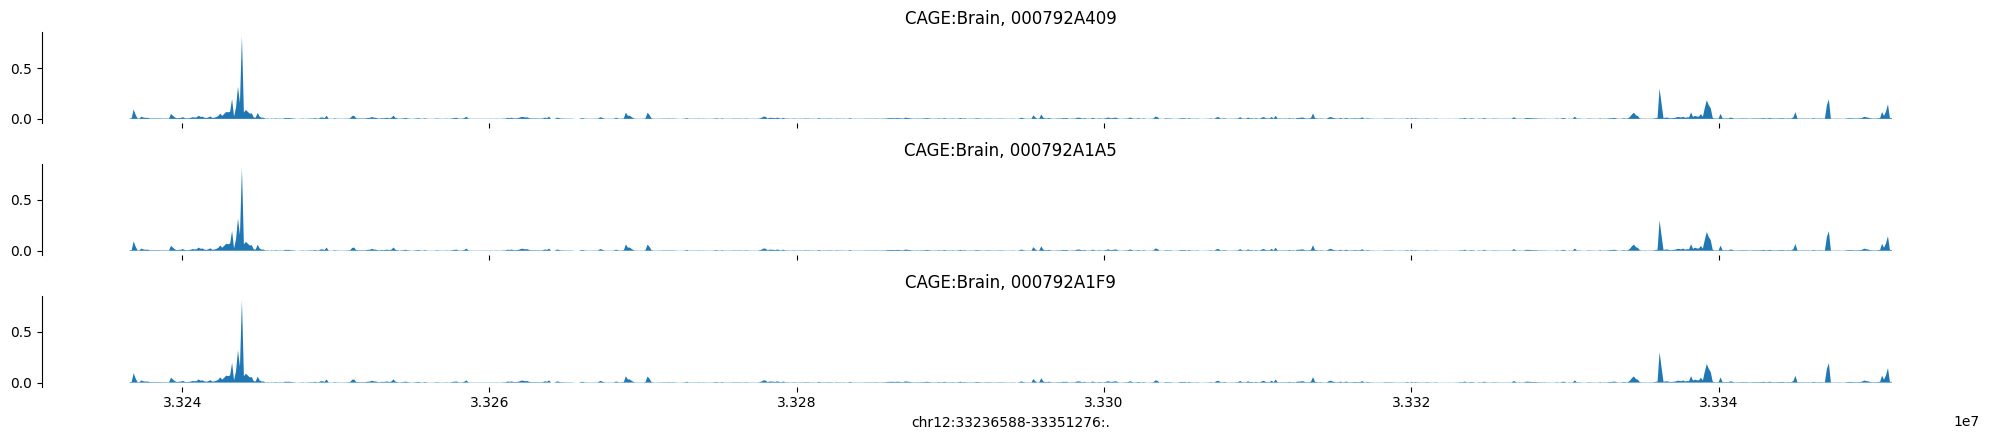

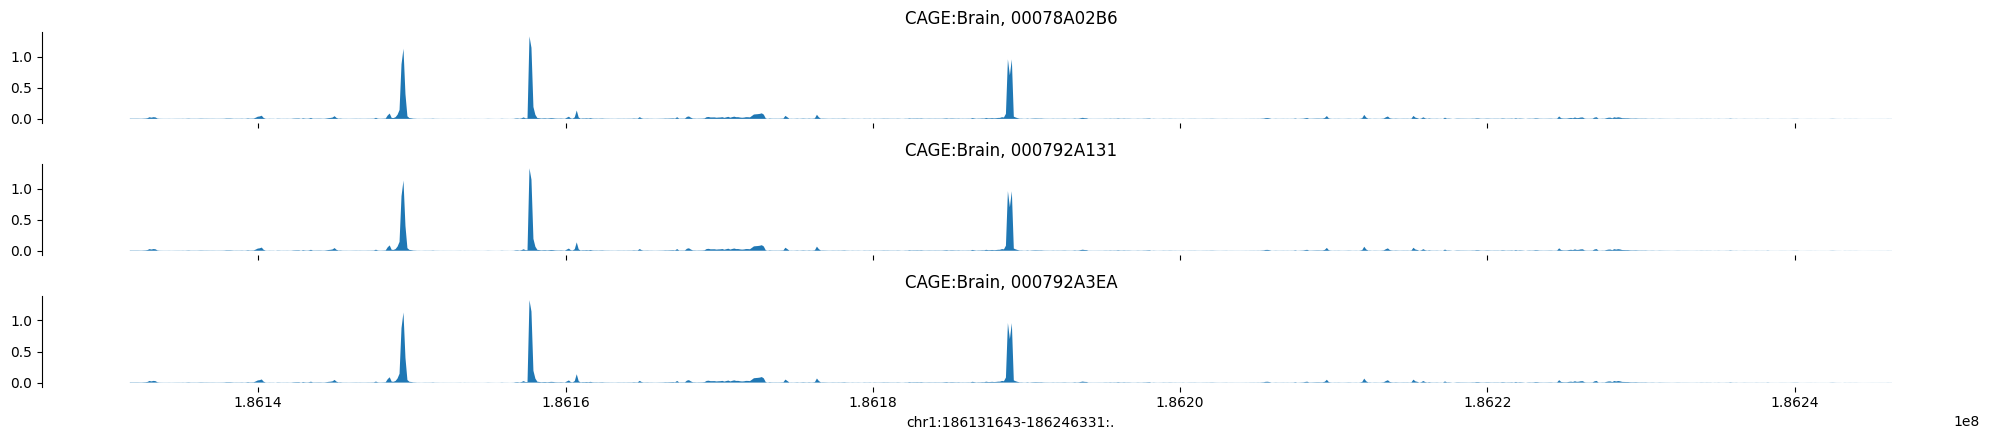

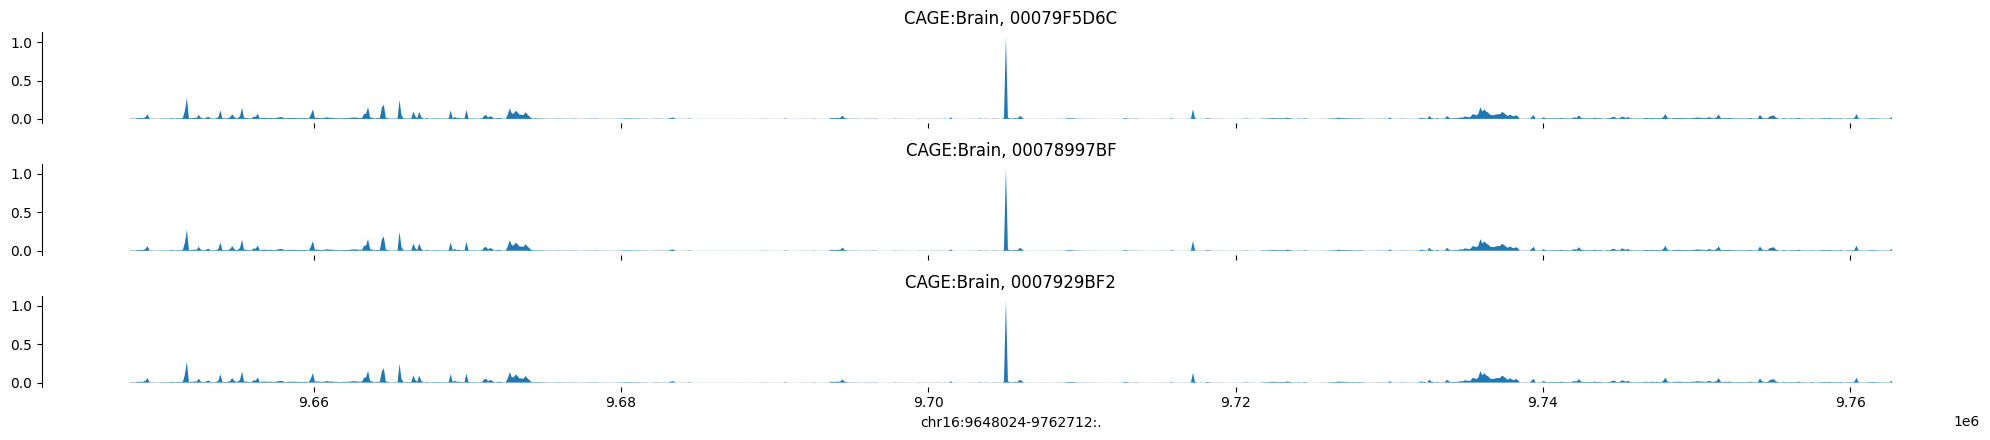

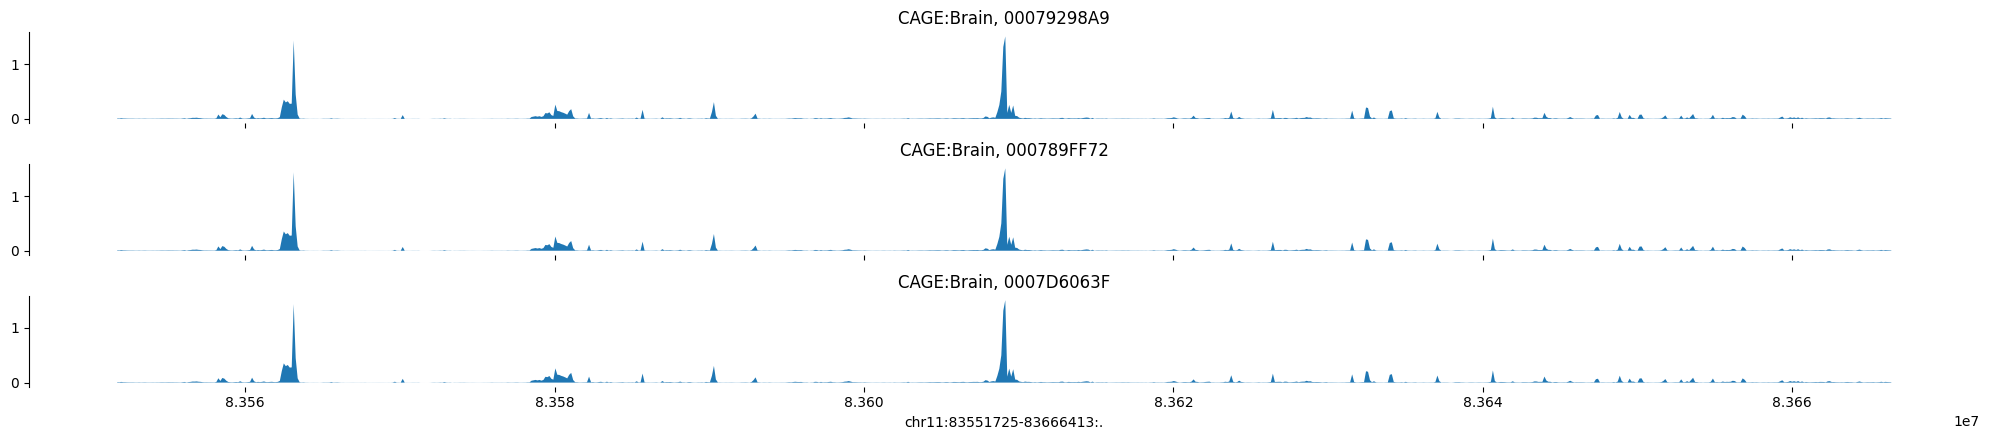

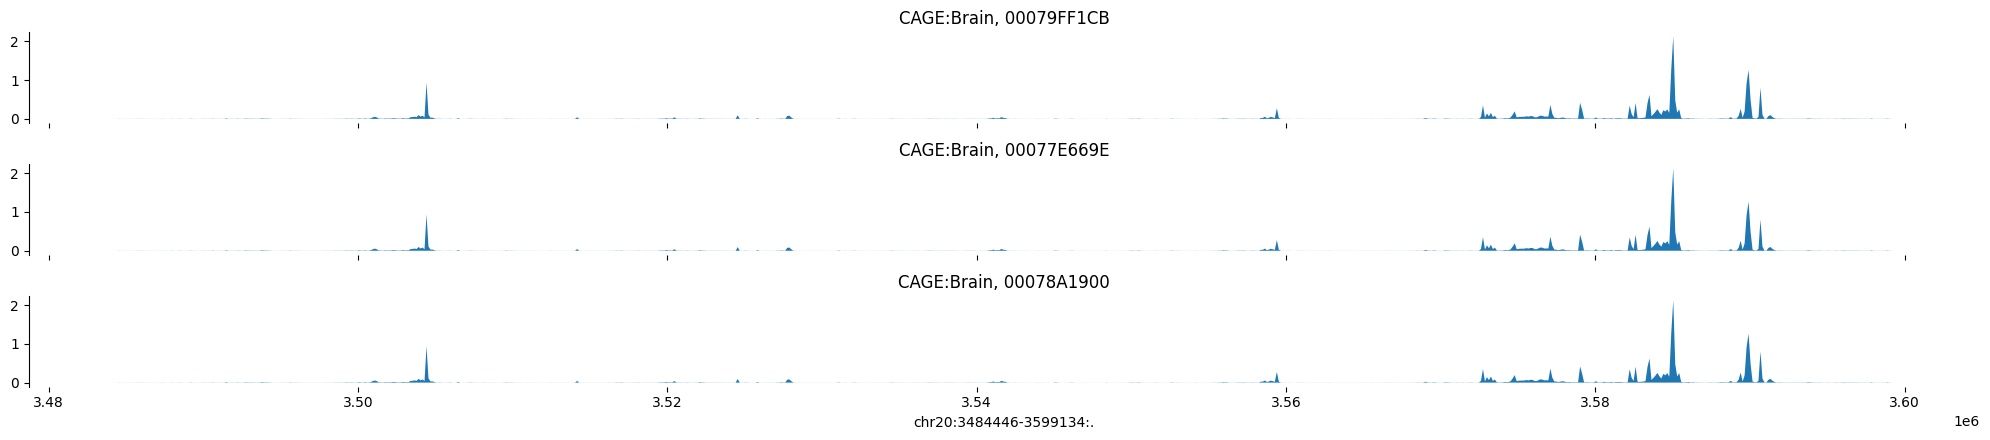

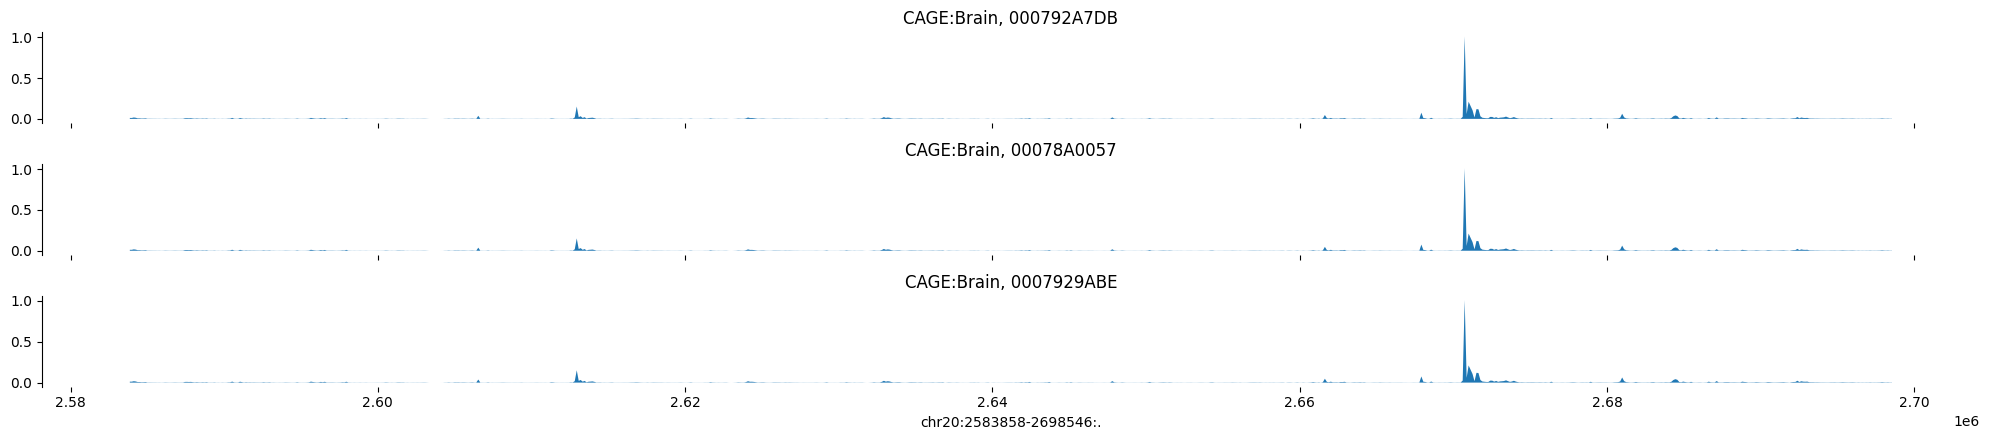

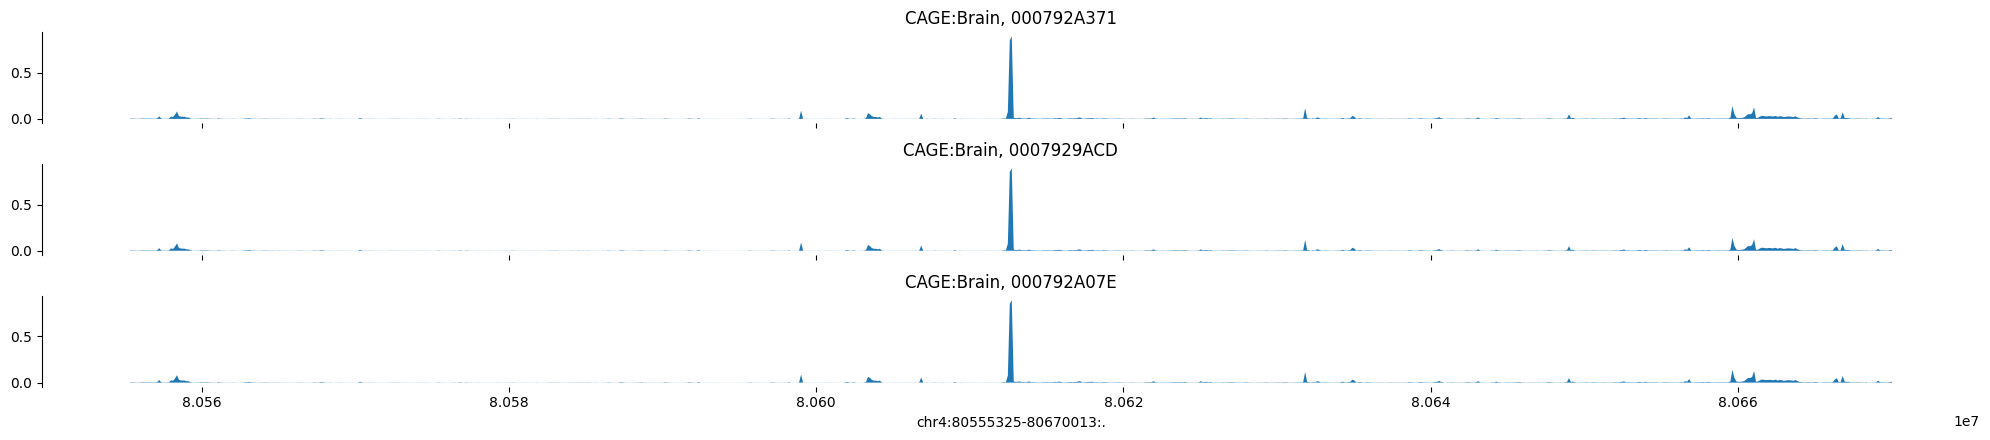

In [55]:
for gene in gene_list:
    plot_individual_tracks(gene)

In [57]:
def plot_predicted_vs_observed(gene):
    df = pred_vs_obs[gene]

    x = df['observed']
    y = df['predicted']
    # Create the dot plot
    plt.scatter(x, y, color='blue', marker='o', s=100)

    # Add labels and title
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title('Enformed Predicted vs Observed Gene Expression')

    # Show the plot
    plt.show()

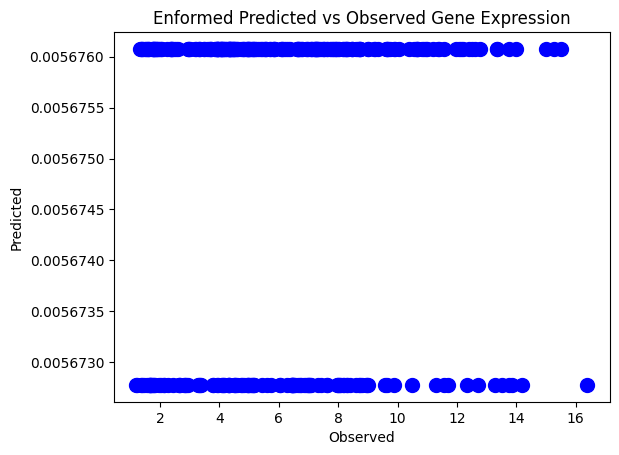

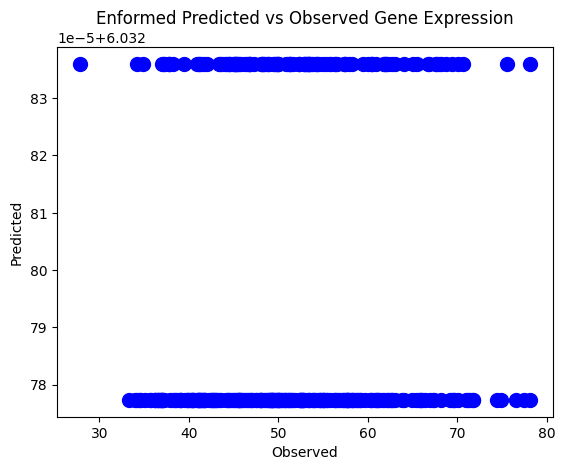

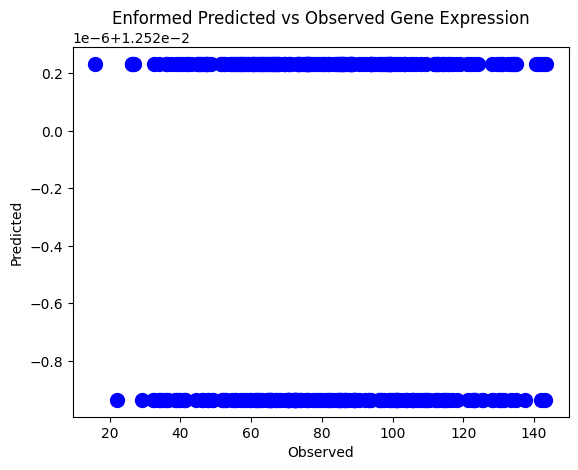

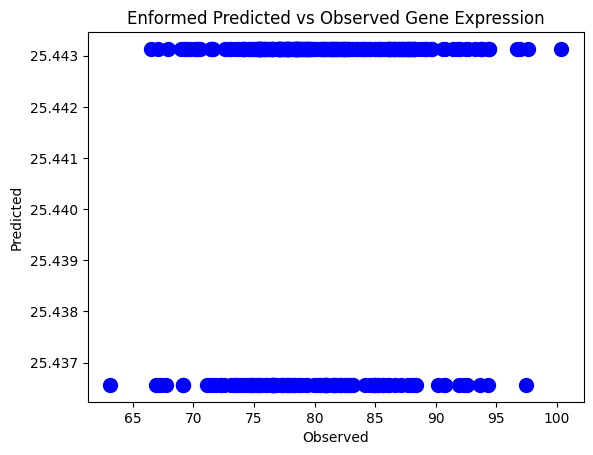

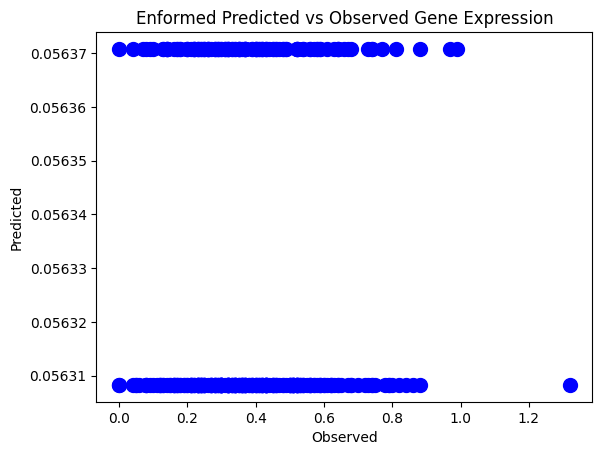

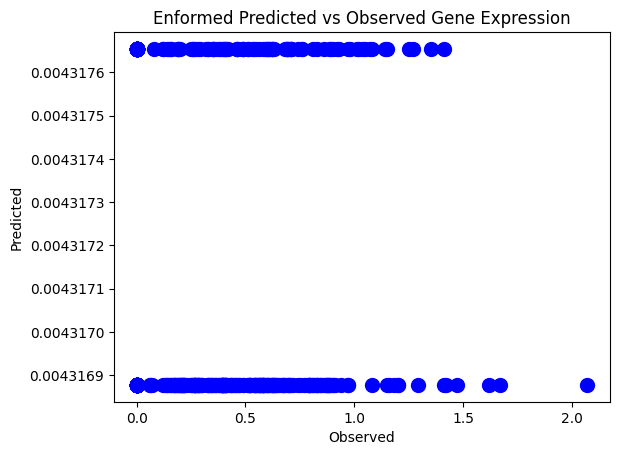

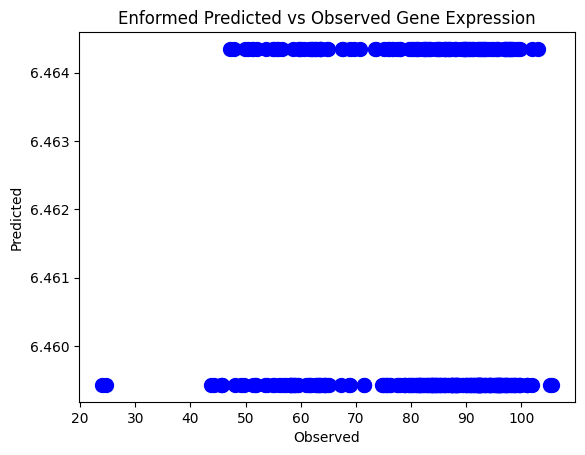

In [58]:
for gene in gene_list:
    plot_predicted_vs_observed(gene)